# A trivial example: Titanic dataset
**That scene**. What a tragedy.
But...

![hadley](../fig/drowning_scene.jpg "title-1")

...what if Jane had some machine learning to choose a better partner, more likely to survive in case of accident?

In [1]:
options(warn=-1)
setwd('~')
source('src/lib.R')

Loading required package: tidyverse
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 2.2.1     v purrr   0.2.4
v tibble  1.4.2     v dplyr   0.7.4
v tidyr   0.8.0     v stringr 1.3.0
v readr   1.1.1     v forcats 0.3.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Loading required package: caret
Loading required package: lattice

Attaching package: 'caret'

The following object is masked from 'package:purrr':

    lift

Loading required package: keras
Loading required package: mlbench
Loading required package: ggthemes
Loading required package: assertthat

Attaching package: 'assertthat'

The following object is masked from 'package:tibble':

    has_name

Loading required package: kernlab

Attaching package: 'kernlab'

The following object is masked from 'package:purrr':

    cross

The following object is masked from 'package:ggplot

In [87]:
# import the data
titanic_df = read_csv('data/titanic.csv')

Parsed with column specification:
cols(
  pclass = col_integer(),
  survived = col_integer(),
  name = col_character(),
  sex = col_character(),
  age = col_double(),
  sibsp = col_integer(),
  parch = col_integer(),
  ticket = col_character(),
  fare = col_double(),
  cabin = col_character(),
  embarked = col_character(),
  boat = col_character(),
  body = col_integer(),
  home.dest = col_character()
)


Randomly choosing a partner aged 18 - 40 is **not a good idea, Rose...**

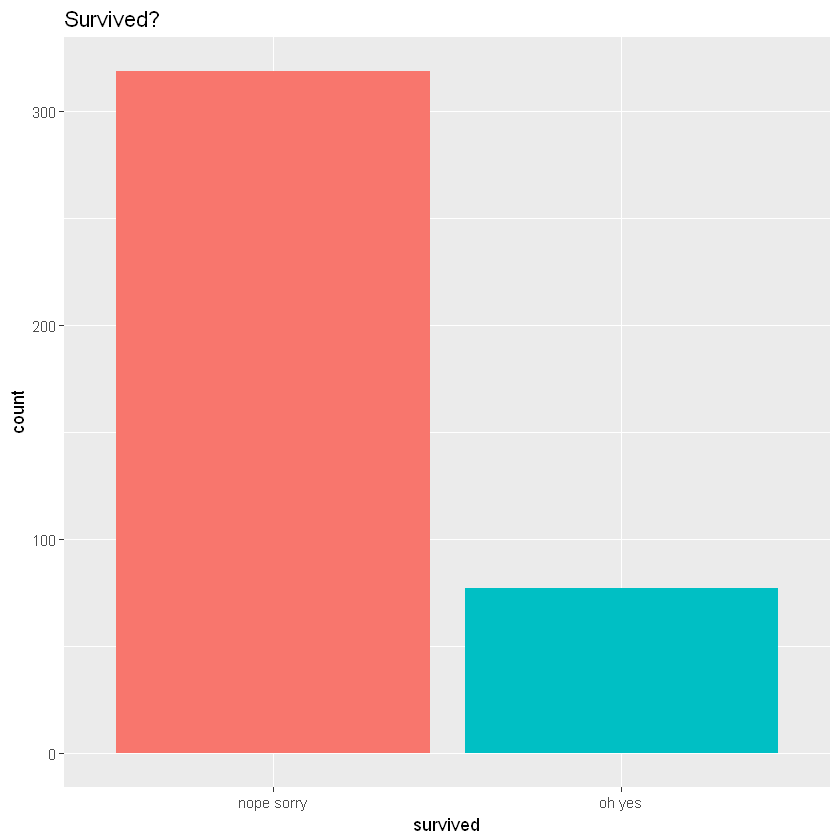

In [86]:
titanic_df %>% filter(sex == 'male', age > 18, age < 40) %>% 
  select(survived) %>% mutate(survived = ifelse(survived == 1, 'oh yes', 'nope sorry')) %>% 
  ggplot(aes(survived, fill = survived)) + geom_bar() + ggtitle('Survived?') + theme(legend.position = "none")

...indeed, approximately 3 every 4 will likely die in case of accident.

In [4]:
titanic_df %>% glimpse

Observations: 1,310
Variables: 14
$ pclass    <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
$ survived  <int> 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, ...
$ name      <chr> "Allen, Miss. Elisabeth Walton", "Allison, Master. Hudson...
$ sex       <chr> "female", "male", "female", "male", "female", "male", "fe...
$ age       <dbl> 29.0000, 0.9167, 2.0000, 30.0000, 25.0000, 48.0000, 63.00...
$ sibsp     <int> 0, 1, 1, 1, 1, 0, 1, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...
$ parch     <int> 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...
$ ticket    <chr> "24160", "113781", "113781", "113781", "113781", "19952",...
$ fare      <dbl> 211.3375, 151.5500, 151.5500, 151.5500, 151.5500, 26.5500...
$ cabin     <chr> "B5", "C22 C26", "C22 C26", "C22 C26", "C22 C26", "E12", ...
$ embarked  <chr> "S", "S", "S", "S", "S", "S", "S", "S", "S", "C", "C", "C...
$ boat      <chr> "2", "11", NA, NA, NA, "3", "10", NA, "D", NA, NA, "4", "...
$ body      <int> 

In [12]:
partition = titanic_df %>% nrow %>% seq_len %>% createDataPartition(times = 1, p = 0.7, list = F)

train_raw = titanic_df %>% slice(partition)
test_raw = titanic_df %>% slice(-partition)

cat('train data size\n')
train_raw %>% dim

cat('test data size\n')
test_raw %>% dim

train data size


[1] 918  14

test data size


[1] 392  14

## Prepare the data for being fed into the model
* convert data types to float / integer
* define rule for managing missing values (*NA*s)
* you could even normalize the features (we are not doing this here)

In [13]:
data_processing = function(df){
  df %>%
    select(survived, # select features
           pclass,
           sex,
           age,
           sibsp,
           parch,
           fare,
           cabin,
           embarked
    ) %>% 
    mutate_if(is.character, fct_explicit_na) %>% # assign levels to missings
    mutate_all(as.numeric) %>% mutate_all(funs(replace(., is.na(.), 0))) # %>% # set missings to 0
    # mutate_all(scale) # normalize data
}

train = data_processing(train_raw)
test = data_processing(test_raw)

In [14]:
train %>% glimpse

Observations: 918
Variables: 9
$ survived <dbl> 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1...
$ pclass   <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...
$ sex      <dbl> 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2...
$ age      <dbl> 30, 25, 48, 63, 71, 47, 26, 0, 32, 37, 47, 42, 29, 25, 25,...
$ sibsp    <dbl> 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0...
$ parch    <dbl> 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0...
$ fare     <dbl> 151.5500, 151.5500, 26.5500, 77.9583, 49.5042, 227.5250, 7...
$ cabin    <dbl> 59, 59, 114, 111, 146, 75, 146, 146, 92, 102, 102, 146, 87...
$ embarked <dbl> 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 3, 1, 3, 1, 1, 1, 3, 3, 3, 1...


## Fit a KNN model and make some predictions

In [16]:
# fit knn

model = train(x = train %>% select(-one_of('survived')),
              y = train %>% select(one_of('survived')) %>% pull %>% factor,
              method = 'kknn',
              tuneGrid = data.frame(kmax = 20,
                                    kernel = c("triangular"),
                                    distance = 0.5)
)

In [43]:
test_response = model %>%
  predict(newdata = test %>% select(-one_of('survived'))) %>% factor

In [85]:
# show predictions for male, aged 18-40

(pred = test_raw %>% bind_cols(data_frame('guess_survived' = test_response)) %>%
  filter(sex == 'male',age > 18, age < 40) %>%
  select(name, sex, age, guess_survived, survived)) %>% head

name,sex,age,guess_survived,survived
"Andrews, Mr. Thomas Jr",male,39,0,0
"Baxter, Mr. Quigg Edmond",male,24,1,0
"Beattie, Mr. Thomson",male,36,0,0
"Behr, Mr. Karl Howell",male,26,0,1
"Carrau, Mr. Francisco M",male,28,0,0
"Clark, Mr. Walter Miller",male,27,1,0


In [83]:
# how good is the model for this subclass?
acc = confusionMatrix(pred$guess_survived, pred$survived %>% factor)
acc$overall[1] %>% round(3)

Accuracy 
   0.797

hey, it seems that now roses has almost 80% chanche of getting the right partner! Awsome!

## Well, probably not. But why?

Stay tuned...